## GoogleLeak

In [9]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc06"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "GoogleLeak",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2017, 8, 25, 3, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2017, 8, 25, 4, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 5m 45s


# Statistical features extraction

In [10]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 5,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 6s


In [11]:
import pandas as pd 
data = pd.read_json(folder+"anomaly/GoogleLeak/transform/Features/Features_5.json")
data

,nb_A,nb_W,nb_implicit_W,nb_dup_A,nb_dup_W,nb_A_prefix,nb_W_prefix,max_A_prefix,avg_A_prefix,max_A_AS,...,editdist_11,editdist_12,editdist_13,editdist_14,editdist_15,editdist_16,editdist_17,nb_tolonger,nb_toshorter,avg_interarrival
0,2727,275,1963,378,0,571,123,54,5,256,...,0,0,0,0,0,0,0,674,1289,1103
1,2462,148,1721,347,0,434,66,51,6,188,...,1,0,0,0,0,0,0,738,983,1133
2,3080,309,2199,320,0,686,181,55,4,314,...,1,0,0,0,0,0,0,889,1310,1116
3,3558,396,2489,595,0,677,263,56,5,360,...,0,0,0,0,0,0,0,968,1521,1068
4,86458,356,3790,7500,0,75578,203,46,1,19182,...,9,13,0,1,0,0,0,1180,2610,1087
5,72353,2120,13534,13980,0,44697,1211,56,2,8135,...,14,11,5,3,0,1,13,4793,8741,1038
6,39806,93395,25632,13416,0,31186,93115,58,1,3037,...,105,26,37,3,0,5,45,10925,14707,1046
7,5813,344,4184,647,0,1947,219,63,3,427,...,9,23,5,1,0,1,63,1412,2772,1072
8,5381,958,3448,391,0,1245,508,51,4,1222,...,2,6,2,0,0,0,70,1270,2178,1099
9,4311,401,3069,625,0,1030,165,54,4,305,...,5,7,1,1,0,0,56,1318,1751,1112


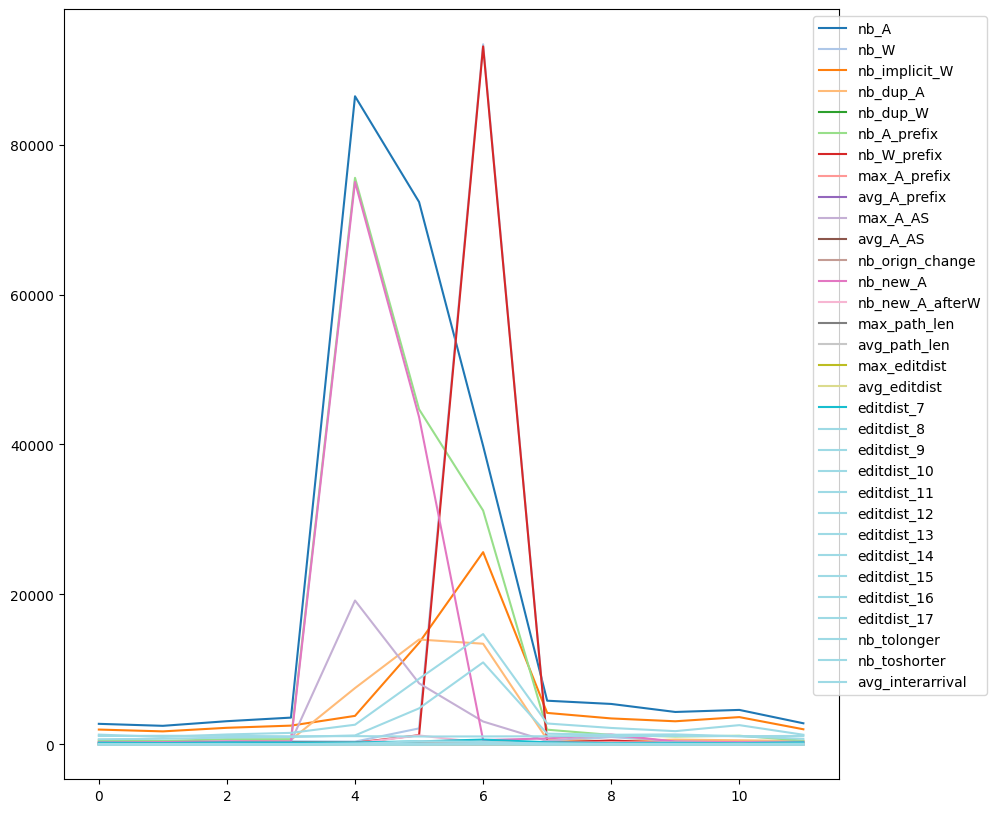

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/GoogleLeak/transform/Features/Features_5.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()


In [15]:
import pandas as pd
import datetime

# Load the data
folder = "dataset/"
data = pd.read_json(folder + "anomaly/GoogleLeak/transform/Features/Features_5.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2017, 8, 25, 3, 15, 0)  # Start time
end_time = datetime.datetime(2017, 8, 25, 3, 45, 0)   # End time

# Generate a list of timestamps for each 5-minute interval between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='5T')  # '5T' frequency is for 5 minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Calculate the difference between consecutive rows
diff = data.diff().abs()

# Define the threshold for each column as mean + 1.5 * std
thresholds = diff.mean() + 1.5 * diff.std()

# Find rows where the difference exceeds the threshold
anomalies = (diff > thresholds).any(axis=1)

# Initialize the anomaly_status column with "no anomalies detected"
data['anomaly_status'] = "no anomalies detected"

# Label anomalies and add reasons
for idx in data[anomalies].index:
    reasons = []
    for col in data.columns[1:]:  # Skip timestamp column and anomaly_status column
        if col == 'anomaly_status':
            continue
        if diff.loc[idx, col] > thresholds[col]:
            reasons.append(f"{col}={data.loc[idx, col]}")
    if reasons:
        data.at[idx, 'anomaly_status'] = f"anomaly due to high value of {', '.join(reasons)}"
    else:
        data.at[idx, 'anomaly_status'] = "normal"

# Display the DataFrame to verify
print(data)

# Save the updated DataFrame to a new JSON file if needed
data.to_json("/home/hb/dataset_bgp/bgp_nlp_dataset/google_leak_main_with_anomalies.json", orient='records', date_format='iso')

Number of rows in the DataFrame: 12
             timestamp   nb_A   nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0  2017-08-25 03:15:00   2727    275           1963       378         0   
1  2017-08-25 03:20:00   2462    148           1721       347         0   
2  2017-08-25 03:25:00   3080    309           2199       320         0   
3  2017-08-25 03:30:00   3558    396           2489       595         0   
4  2017-08-25 03:35:00  86458    356           3790      7500         0   
5  2017-08-25 03:40:00  72353   2120          13534     13980         0   
6  2017-08-25 03:45:00  39806  93395          25632     13416         0   
7  2017-08-25 03:50:00   5813    344           4184       647         0   
8  2017-08-25 03:55:00   5381    958           3448       391         0   
9  2017-08-25 04:00:00   4311    401           3069       625         0   
10 2017-08-25 04:05:00   4585    354           3625       532         0   
11 2017-08-25 04:10:00   2800    260           2002       436   

## February 2021 Cablevision Mexico

In [13]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["route-views.sg", "route-views.eqix"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "Mexico_cable",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2021, 2, 11, 4, 30, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2021, 2, 11, 6, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 20m 42s


In [14]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 5,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 2
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/2 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 59s


In [15]:
data = pd.read_json(folder + "anomaly/Mexico_cable/transform/Features/Features_5.json")
data

,nb_A,nb_W,nb_implicit_W,nb_dup_A,nb_dup_W,nb_A_prefix,nb_W_prefix,max_A_prefix,avg_A_prefix,max_A_AS,...,editdist_11,editdist_12,editdist_13,editdist_14,editdist_15,editdist_16,editdist_17,nb_tolonger,nb_toshorter,avg_interarrival
0,167532,8484,73553,74723,344,28249,3167,6100,6,12161,...,215,260,236,29,53,36,26,25626,47927,1000
1,144350,6337,50024,73472,366,30075,1225,5274,5,10553,...,183,254,113,9,20,0,25,18239,31785,1000
2,200224,10746,84342,90106,846,24026,1385,4834,8,9661,...,1292,225,82,93,48,13,7,25523,58819,1000
3,148202,5924,60064,78454,356,22933,936,5563,6,11141,...,216,201,46,10,31,0,5,18579,41485,1000
4,119193,3309,47837,65627,142,21445,534,5334,6,10423,...,87,41,25,14,10,0,1,11609,36228,1000
5,143991,6280,54314,78735,331,24509,1466,5584,6,11102,...,64,141,29,6,17,0,3,16711,37603,1000
6,174691,5625,70031,93610,498,29344,664,5261,6,10509,...,234,263,141,38,51,11,2,25147,44884,1000
7,137228,4829,44872,81866,327,25670,579,6253,5,12323,...,178,299,49,1,28,0,7,16089,28783,1000
8,196345,6857,85308,97444,461,31739,887,6522,6,12897,...,341,184,121,34,62,44,14,28934,56374,1000
9,195099,9317,82378,85724,556,35268,1309,3010,6,8367,...,274,151,50,12,46,12,4,25511,56867,1000


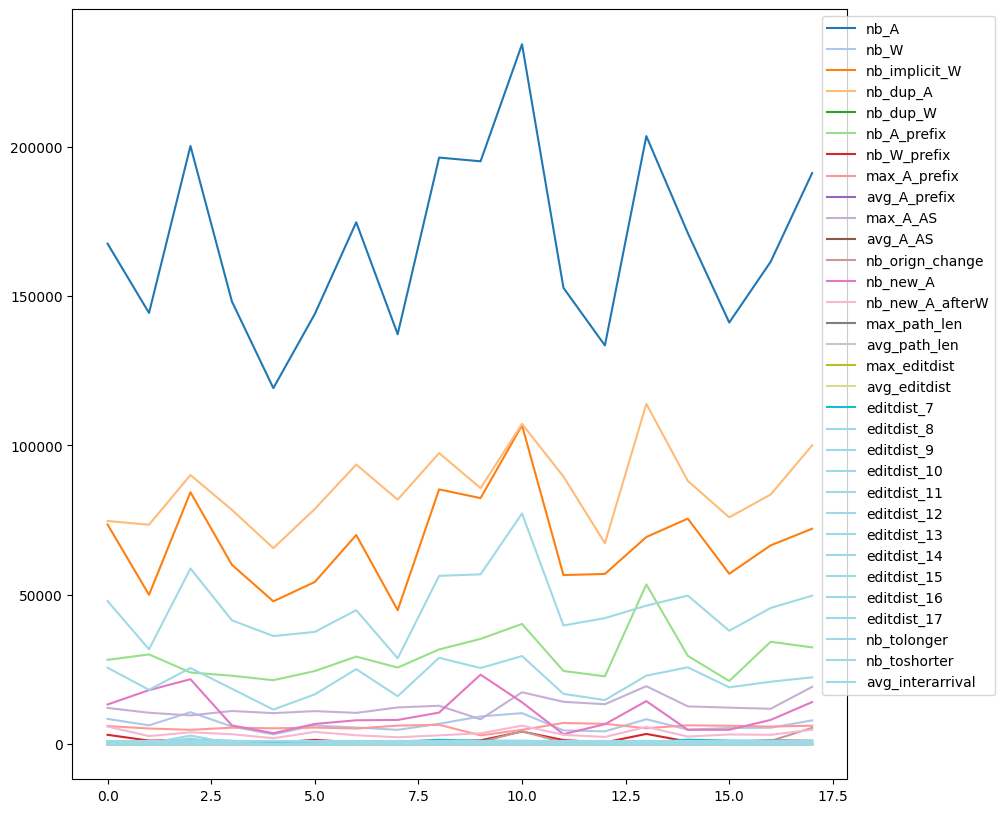

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/Mexico_cable/transform/Features/Features_5.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import datetime

data = pd.read_json(folder + "anomaly/Mexico_cable/transform/Features/Features_5.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2021, 2, 11, 4, 30, 0)  # Start time
end_time = datetime.datetime(2021, 2, 11, 6, 0, 0)    # End time

# Generate a list of timestamps for each minute between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='T')  # 'T' frequency is for minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Display the DataFrame to verify
print(data.head())
# Save the updated DataFrame to a new JSON file if needed
data.to_json(folder + "anomaly/Mexico_cable/transform/Features/mexico_cable_features.json", orient='records', date_format='iso')


Number of rows in the DataFrame: 90
            timestamp   nb_A  nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0 2021-02-11 00:00:00  39212   878          19605     17449        46   
1 2021-02-11 00:01:00  27222  1113          11972     12954        36   
2 2021-02-11 00:02:00  27414  3677          15389      8206       133   
3 2021-02-11 00:03:00  25853   985           8271     14060        71   
4 2021-02-11 00:04:00  47831  1831          18316     22054        54   

   nb_A_prefix  nb_W_prefix  max_A_prefix  avg_A_prefix  ...  editdist_11  \
0        13080          468          1490             3  ...           57   
1        10572          573           889             3  ...           33   
2        10597         2232           972             3  ...           39   
3         9670          327          1473             3  ...           14   
4        13982          850          1303             3  ...           72   

   editdist_12  editdist_13  editdist_14  editdist_15  editdis

## April 2018: 1300 IP addresses within Amazon Web Services space were hijacked by eNet

In [17]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc00", "rrc06"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "Amazon_enet",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2018, 4, 25, 8, 30, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2018, 4, 25, 12, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 17m 32s


In [18]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 5,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 3
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/3 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 1m 23s


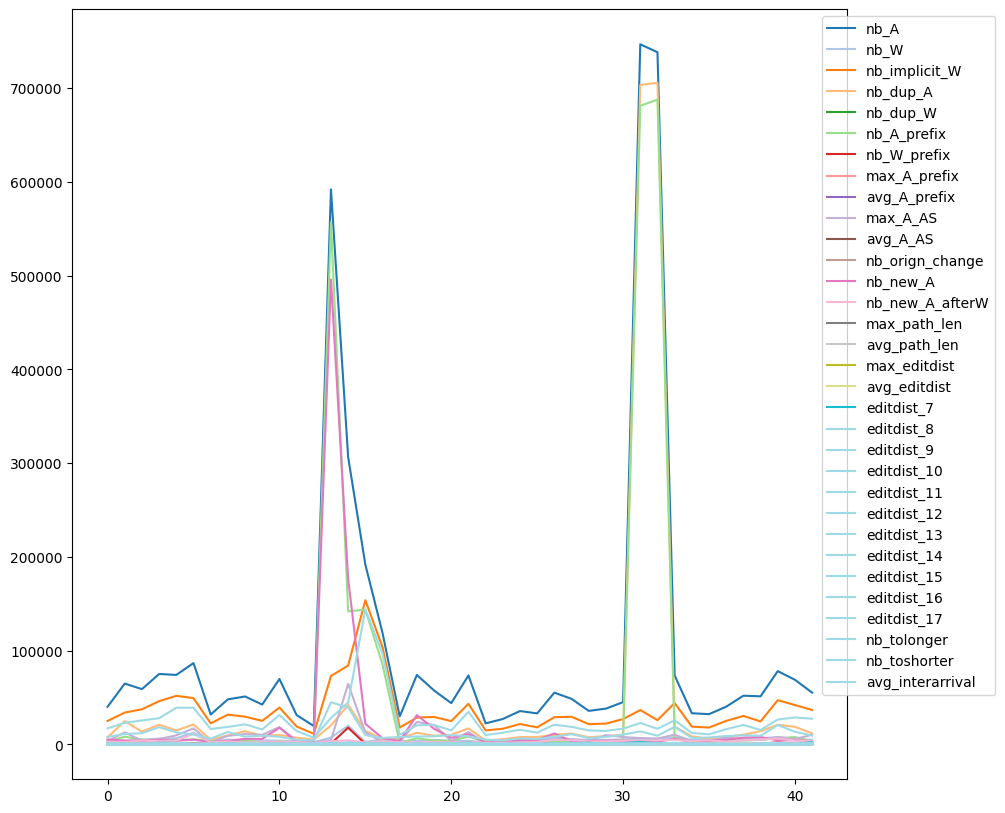

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

folder = "dataset/"
data = pd.read_json(folder + "anomaly/Amazon_enet/transform/Features/Features_5.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [6]:
import pandas as pd
import datetime

folder = "dataset/"
data = pd.read_json(folder + "anomaly/Amazon_enet/transform/Features/Features_5.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2017, 8, 25, 3, 15, 0)  # Start time
end_time = datetime.datetime(2017, 8, 25, 3, 45, 0)   # End time

# Generate a list of timestamps for each 5-minute interval between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='5T')  # '5T' frequency is for 5 minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Calculate the difference between consecutive rows
diff = data.diff().abs()

# Define the threshold for each column as mean + 1.5 * std
thresholds = diff.mean() + 4 * diff.std()

# Find rows where the difference exceeds the threshold
anomalies = (diff > thresholds).any(axis=1)

# Initialize the anomaly_status column with "no anomalies detected"
data['anomaly_status'] = "no anomalies detected"

# Label anomalies and add reasons
for idx in data[anomalies].index:
    reasons = []
    for col in data.columns[1:]:  # Skip timestamp column and anomaly_status column
        if col == 'anomaly_status':
            continue
        if diff.loc[idx, col] > thresholds[col]:
            reasons.append(f"{col}={data.loc[idx, col]}")
    if reasons:
        data.at[idx, 'anomaly_status'] = f"anomaly due to high value of {', '.join(reasons)}"
    else:
        data.at[idx, 'anomaly_status'] = "normal"

# Display the DataFrame to verify
print(data)

# Save the updated DataFrame to a new JSON file if needed
data.to_json("/home/hb/dataset_bgp/bgp_nlp_dataset/amazon_enet_main.json", orient='records', date_format='iso')


Number of rows in the DataFrame: 42
             timestamp    nb_A   nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0  2017-08-25 03:15:00   40022   4311          24826      7454         1   
1  2017-08-25 03:20:00   64782   3562          33825     24662         0   
2  2017-08-25 03:25:00   58851   4979          37344     13491         0   
3  2017-08-25 03:30:00   74995   6046          46017     20853         0   
4  2017-08-25 03:35:00   74019   6398          51690     14740         1   
5  2017-08-25 03:40:00   86629  12444          49253     21159         1   
6  2017-08-25 03:45:00   31791   2820          22315      4862         0   
7  2017-08-25 03:50:00   47941   4974          31632      9485        16   
8  2017-08-25 03:55:00   50997   2644          29462     13979         0   
9  2017-08-25 04:00:00   42397   4187          24993      9029         2   
10 2017-08-25 04:05:00   69660   3912          39174      9973         1   
11 2017-08-25 04:10:00   31196   3148          18974

## December 2017: Eighty high-traffic prefixes normally announced by Google, Apple, Facebook

In [2]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["route-views2", "route-views3", "route-views4", "ris-ripe"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "high_traffic_prefixes_FANG",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2017, 12, 12, 6, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2017, 12, 12, 8, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 30m 7s


In [3]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 5,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 4
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/4 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 2m 25s


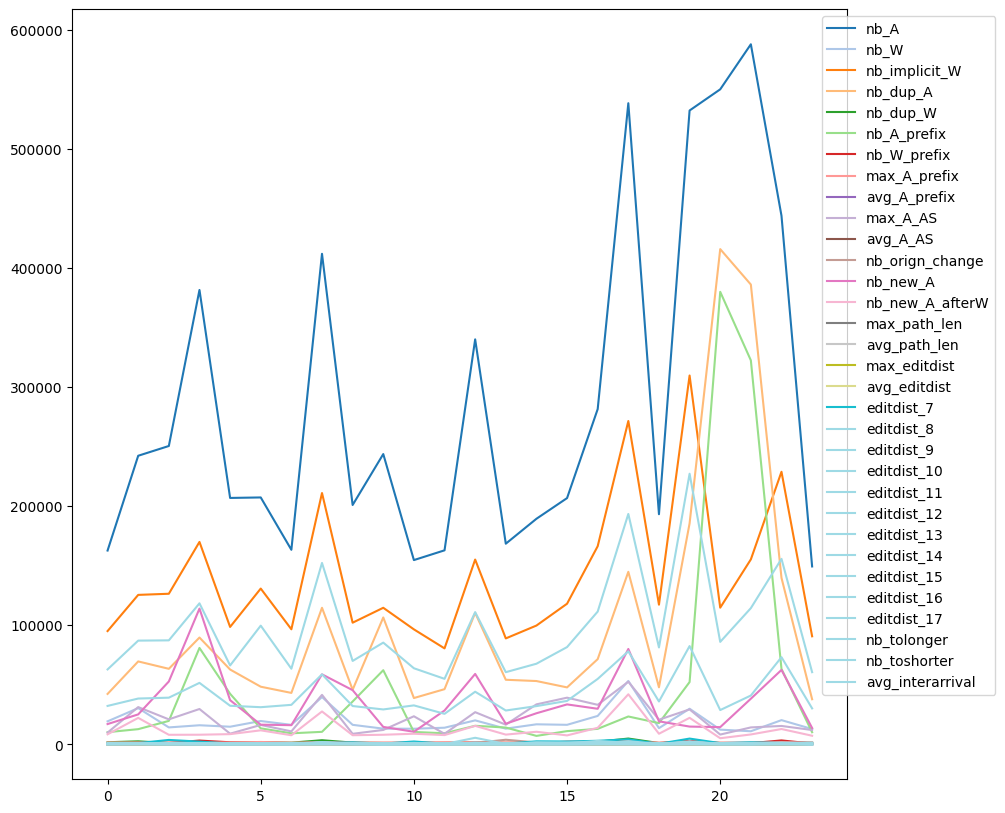

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/high_traffic_prefixes_FANG/transform/Features/Features_5.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [17]:
import pandas as pd
import datetime

data = pd.read_json("/home/hb/BGP_data_analysis/bml/BML/dataset/anomaly/high_traffic_prefixes_FANG/transform/Features/Features_5.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2017, 8, 25, 3, 15, 0)  # Start time
end_time = datetime.datetime(2017, 8, 25, 3, 45, 0)   # End time

# Generate a list of timestamps for each 5-minute interval between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='5T')  # '5T' frequency is for 5 minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Calculate the difference between consecutive rows
diff = data.diff().abs()

# Define the threshold for each column as mean + 1.5 * std
thresholds = diff.mean() + 1.5 * diff.std()

# Find rows where the difference exceeds the threshold
anomalies = (diff > thresholds).any(axis=1)

# Initialize the anomaly_status column with "no anomalies detected"
data['anomaly_status'] = "no anomalies detected"

# Label anomalies and add reasons
for idx in data[anomalies].index:
    reasons = []
    for col in data.columns[1:]:  # Skip timestamp column and anomaly_status column
        if col == 'anomaly_status':
            continue
        if diff.loc[idx, col] > thresholds[col]:
            reasons.append(f"{col}={data.loc[idx, col]}")
    if reasons:
        data.at[idx, 'anomaly_status'] = f"anomaly due to high value of {', '.join(reasons)}"
    else:
        data.at[idx, 'anomaly_status'] = "normal"

# Display the DataFrame to verify
print(data)

# Save the updated DataFrame to a new JSON file if needed
data.to_json("/home/hb/dataset_bgp/bgp_nlp_dataset/high_traffic_FANG_main.json", orient='records', date_format='iso')


Number of rows in the DataFrame: 24
             timestamp    nb_A   nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0  2017-08-25 03:15:00  162747  19280          95102     42297      1712   
1  2017-08-25 03:20:00  242374  30370         125498     69600      2455   
2  2017-08-25 03:25:00  250572  14168         126451     63398      1058   
3  2017-08-25 03:30:00  381658  15982         169989     89664      1399   
4  2017-08-25 03:35:00  206940  14751          98569     62799      1145   
5  2017-08-25 03:40:00  207350  19544         130811     48360      1703   
6  2017-08-25 03:45:00  163374  16327          96596     43150      1353   
7  2017-08-25 03:50:00  412026  39690         211056    114653      3396   
8  2017-08-25 03:55:00  201011  16333         102141     45798      1400   
9  2017-08-25 04:00:00  243795  13130         114664    106539      1059   
10 2017-08-25 04:05:00  154734  13058          96528     38840      1154   
11 2017-08-25 04:10:00  162927  13908          80554

## April 8, 2010 Chinese ISP hijacks the Internet

In [30]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["route-views2", "route-views3", "route-views4", "ris-ripe"],
})

dataset.setPeriodsOfInterests([
    {
    "name": "china_isp_hijack",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2010, 4, 8, 7, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2010, 4, 8, 22, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 12m 2s


In [32]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 5,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 5
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/5 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 2m 35s


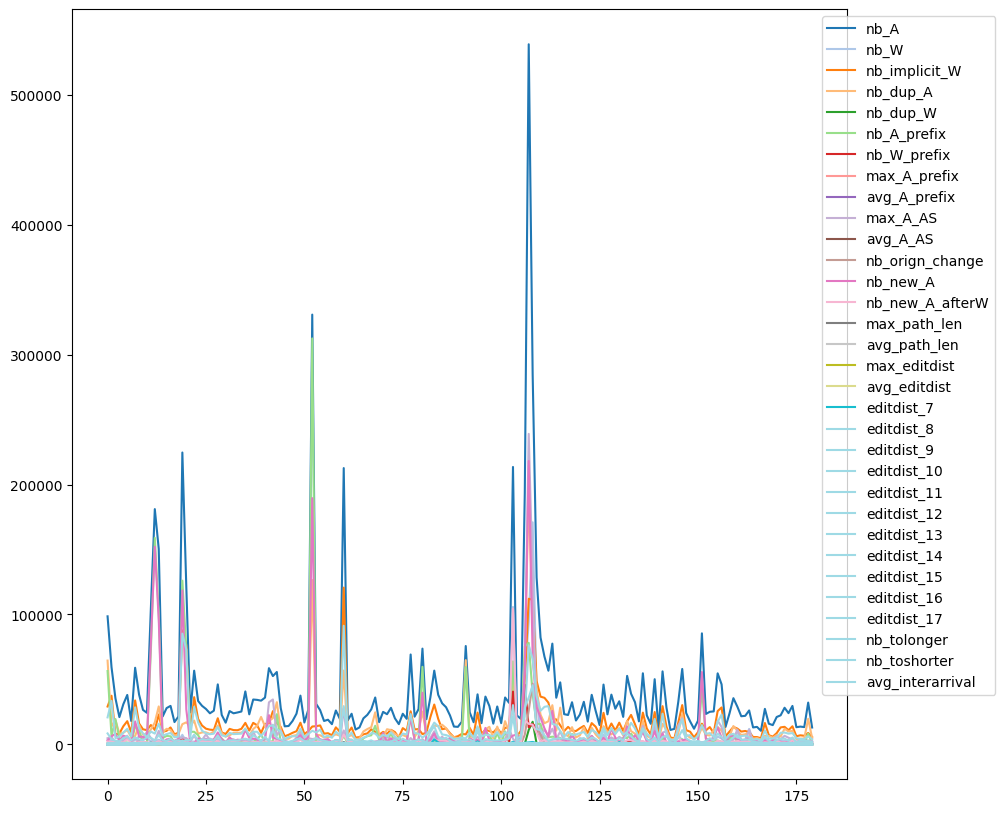

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/china_isp_hijack/transform/Features/Features_5.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [8]:
import pandas as pd
import datetime

data = pd.read_json("/home/hb/BGP_data_analysis/bml/BML/dataset/anomaly/china_isp_hijack/transform/Features/Features_5.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2010, 4, 8, 7, 0, 0)  # Start time
end_time = datetime.datetime(2010, 4, 8, 22, 0, 0)   # End time

# Generate a list of timestamps for each 5-minute interval between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='5T')  # '5T' frequency is for 5 minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Calculate the difference between consecutive rows
diff = data.diff().abs()

# Define the threshold for each column as mean + 1.5 * std
thresholds = diff.mean() + 5 * diff.std()

# Find rows where the difference exceeds the threshold
anomalies = (diff > thresholds).any(axis=1)

# Initialize the anomaly_status column with "no anomalies detected"
data['anomaly_status'] = "no anomalies detected"

# Label anomalies and add reasons
for idx in data[anomalies].index:
    reasons = []
    for col in data.columns[1:]:  # Skip timestamp column and anomaly_status column
        if col == 'anomaly_status':
            continue
        if diff.loc[idx, col] > thresholds[col]:
            reasons.append(f"{col}={data.loc[idx, col]}")
    if reasons:
        data.at[idx, 'anomaly_status'] = f"anomaly due to high value of {', '.join(reasons)}"
    else:
        data.at[idx, 'anomaly_status'] = "normal"

# Display the DataFrame to verify
print(data)

# Save the updated DataFrame to a new JSON file if needed
data.to_json("/home/hb/dataset_bgp/bgp_nlp_dataset/china_isp_hijack.json", orient='records', date_format='iso')


Number of rows in the DataFrame: 180
              timestamp   nb_A  nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0   2010-04-08 07:00:00  98565  3663          29080     64484       269   
1   2010-04-08 07:05:00  59418  2862          37407     13832       185   
2   2010-04-08 07:10:00  35406  2072           7441     18577       150   
3   2010-04-08 07:15:00  20929  2722           8268      8126       226   
4   2010-04-08 07:20:00  30832  4724          13875      8911       419   
..                  ...    ...   ...            ...       ...       ...   
175 2010-04-08 21:35:00  13152  1284           6184      4037        92   
176 2010-04-08 21:40:00  13612  2938           6908      4325       242   
177 2010-04-08 21:45:00  13246  2805           6561      4424       228   
178 2010-04-08 21:50:00  32108  3058           8727     19650       168   
179 2010-04-08 21:55:00  12906  1517           5610      4823       122   

     nb_A_prefix  nb_W_prefix  max_A_prefix  avg_A_prefix  ...

In [20]:
data["anomaly_status"]

100                                no anomalies detected
101                                no anomalies detected
102                                no anomalies detected
103    anomaly due to high value of nb_W=105763, nb_W...
104    anomaly due to high value of nb_W=2129, nb_W_p...
105                                no anomalies detected
106       anomaly due to high value of nb_W_prefix=45917
107    anomaly due to high value of nb_A=539241, nb_d...
108    anomaly due to high value of max_A_AS=128278, ...
109    anomaly due to high value of nb_W=39434, nb_du...
110                                no anomalies detected
111                                no anomalies detected
112                                no anomalies detected
113                                no anomalies detected
114                                no anomalies detected
115                                no anomalies detected
116                                no anomalies detected
117                            

## ROS - Special Operations Group of the Italian National Military police

In [34]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["route-views2", "route-views3", "route-views4", "ris-ripe"],
})

dataset.setPeriodsOfInterests([
    {
    "name": "ros_italy",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2013, 7, 3, 4, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2013, 7, 3, 22, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 20m 51s


In [35]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 5,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 6
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/6 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 5m 10s


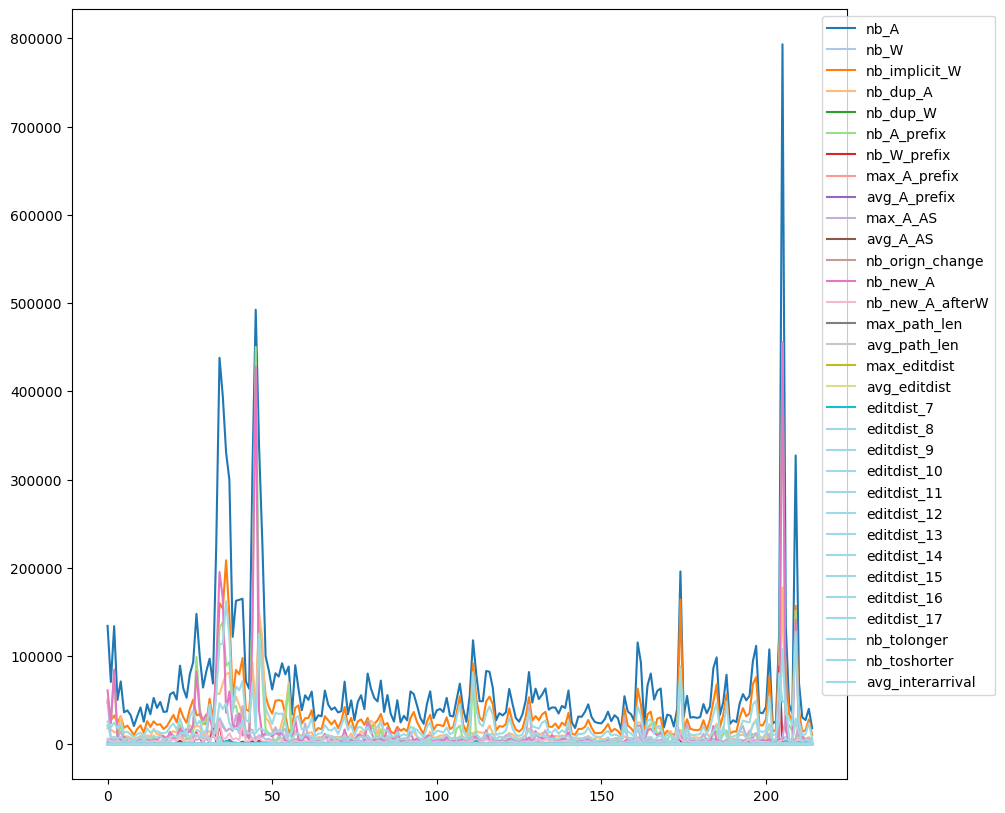

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/ros_italy/transform/Features/Features_5.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [21]:
import pandas as pd
import datetime

data = pd.read_json("/home/hb/BGP_data_analysis/bml/BML/dataset/anomaly/ros_italy/transform/Features/Features_5.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2013, 7, 3, 4, 0, 0)  # Start time
end_time = datetime.datetime(2013, 7, 3, 22, 0, 0)   # End time

# Generate a list of timestamps for each 5-minute interval between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='5T')  # '5T' frequency is for 5 minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Calculate the difference between consecutive rows
diff = data.diff().abs()

# Define the threshold for each column as mean + 1.5 * std
thresholds = diff.mean() + 5 * diff.std()

# Find rows where the difference exceeds the threshold
anomalies = (diff > thresholds).any(axis=1)

# Initialize the anomaly_status column with "no anomalies detected"
data['anomaly_status'] = "no anomalies detected"

# Label anomalies and add reasons
for idx in data[anomalies].index:
    reasons = []
    for col in data.columns[1:]:  # Skip timestamp column and anomaly_status column
        if col == 'anomaly_status':
            continue
        if diff.loc[idx, col] > thresholds[col]:
            reasons.append(f"{col}={data.loc[idx, col]}")
    if reasons:
        data.at[idx, 'anomaly_status'] = f"anomaly due to high value of {', '.join(reasons)}"
    else:
        data.at[idx, 'anomaly_status'] = "normal"

# Display the DataFrame to verify
print(data)

# Save the updated DataFrame to a new JSON file if needed
data.to_json("/home/hb/dataset_bgp/bgp_nlp_dataset/ros_italy.json", orient='records', date_format='iso')


Number of rows in the DataFrame: 215
              timestamp    nb_A   nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0   2013-07-03 04:00:00  134159   6129          47629     21086       213   
1   2013-07-03 04:05:00   70608   5253          27237     16631       276   
2   2013-07-03 04:10:00  133847   4816          32563     13775       210   
3   2013-07-03 04:15:00   50214   5868          24907     13030       296   
4   2013-07-03 04:20:00   71211   6296          31455     32192       303   
..                  ...     ...    ...            ...       ...       ...   
210 2013-07-03 21:30:00   69995  14124          38297     14581       761   
211 2013-07-03 21:35:00   30425   2167          14018      6446       103   
212 2013-07-03 21:40:00   27476   3087          16146      6390       148   
213 2013-07-03 21:45:00   40149   2493          28160      8078       105   
214 2013-07-03 21:50:00   18227   3284          10582      4746       187   

     nb_A_prefix  nb_W_prefix  max_A_p

## January 2017: Iranian pornography censorship

In [7]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["route-views2", "route-views3", "route-views4", "ris-ripe"],
})

dataset.setPeriodsOfInterests([
    {
    "name": "iran_censor",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2017, 1, 5, 4, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2017, 1, 5, 10, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 51m 17s


In [8]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 5,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 7
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/7 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 9m 27s


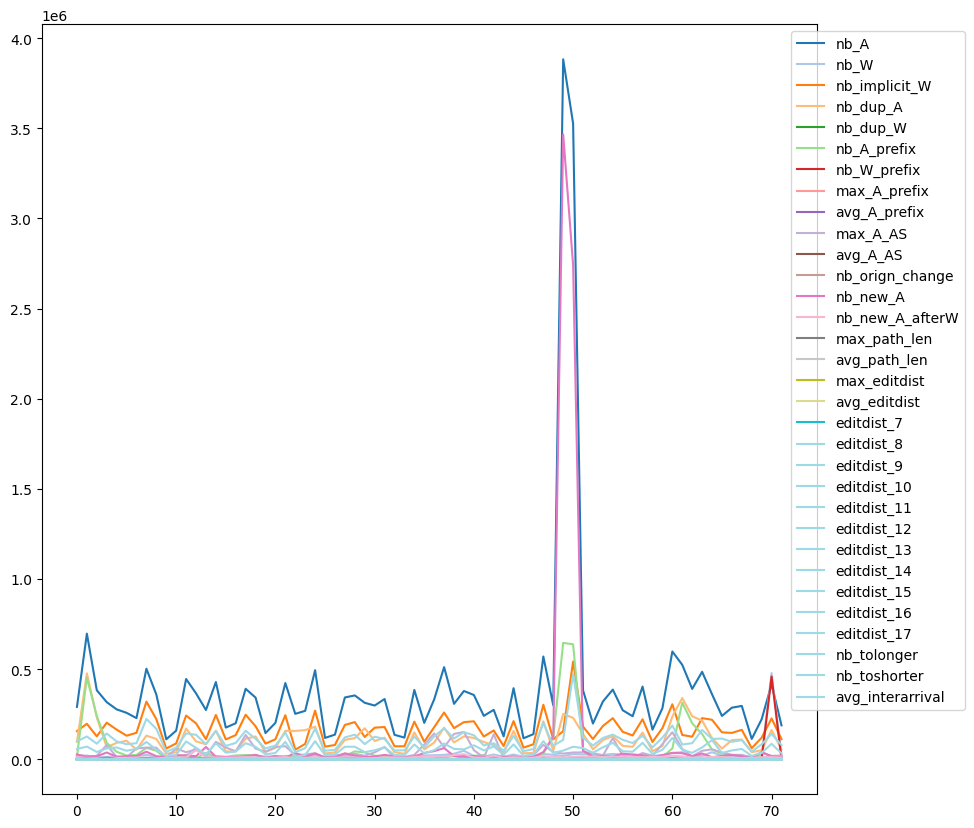

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/iran_censor/transform/Features/Features_5.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [25]:
import pandas as pd
import datetime

data = pd.read_json("/home/hb/BGP_data_analysis/bml/BML/dataset/anomaly/iran_censor/transform/Features/Features_5.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2017, 1, 5, 4, 0, 0) # Start time
end_time = datetime.datetime(2017, 1, 5, 10, 0, 0)  # End time

# Generate a list of timestamps for each 5-minute interval between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='5T')  # '5T' frequency is for 5 minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Calculate the difference between consecutive rows
diff = data.diff().abs()

# Define the threshold for each column as mean + 1.5 * std
thresholds = diff.mean() + 5 * diff.std()

# Find rows where the difference exceeds the threshold
anomalies = (diff > thresholds).any(axis=1)

# Initialize the anomaly_status column with "no anomalies detected"
data['anomaly_status'] = "no anomalies detected"

# Label anomalies and add reasons
for idx in data[anomalies].index:
    reasons = []
    for col in data.columns[1:]:  # Skip timestamp column and anomaly_status column
        if col == 'anomaly_status':
            continue
        if diff.loc[idx, col] > thresholds[col]:
            reasons.append(f"{col}={data.loc[idx, col]}")
    if reasons:
        data.at[idx, 'anomaly_status'] = f"anomaly due to high value of {', '.join(reasons)}"
    else:
        data.at[idx, 'anomaly_status'] = "normal"

# Display the DataFrame to verify
print(data)

# Save the updated DataFrame to a new JSON file if needed
data.to_json("/home/hb/dataset_bgp/bgp_nlp_dataset/iran_censor.json", orient='records', date_format='iso')

Number of rows in the DataFrame: 72
             timestamp    nb_A    nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0  2017-01-05 04:00:00  290703   17700         156196     96603      1446   
1  2017-01-05 04:05:00  696796   20459         196860    476801      1752   
2  2017-01-05 04:10:00  382966   12048         127165    232586      1145   
3  2017-01-05 04:15:00  316839   13721         202935     66484      1058   
4  2017-01-05 04:20:00  276857   14201         164557     90880      1084   
..                 ...     ...     ...            ...       ...       ...   
67 2017-01-05 09:35:00  295898   14254         163323    109440      1254   
68 2017-01-05 09:40:00  112874   10503          61733     39011      1082   
69 2017-01-05 09:45:00  221847   21790         119437     50354      1946   
70 2017-01-05 09:50:00  416140  478112         226547    162197      1373   
71 2017-01-05 09:55:00  188401   18323         112148     53841      1641   

    nb_A_prefix  nb_W_prefix  max_A_pre

## Test dataset: Taiwan hijack

In [20]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc00", "route-views1.saopaulo", "route-views2.saopaulo"],
})

dataset.setPeriodsOfInterests([
    {
    "name": "test_taiwan",
    "label": "anomaly",
    "start_time": utils.getTimestamp(2019, 5, 8, 14, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2019, 5, 8, 15, 30, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 27m 10s


In [21]:
from BML.transform import DatasetTransformation

# features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 5,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 8
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/8 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 1m 21s


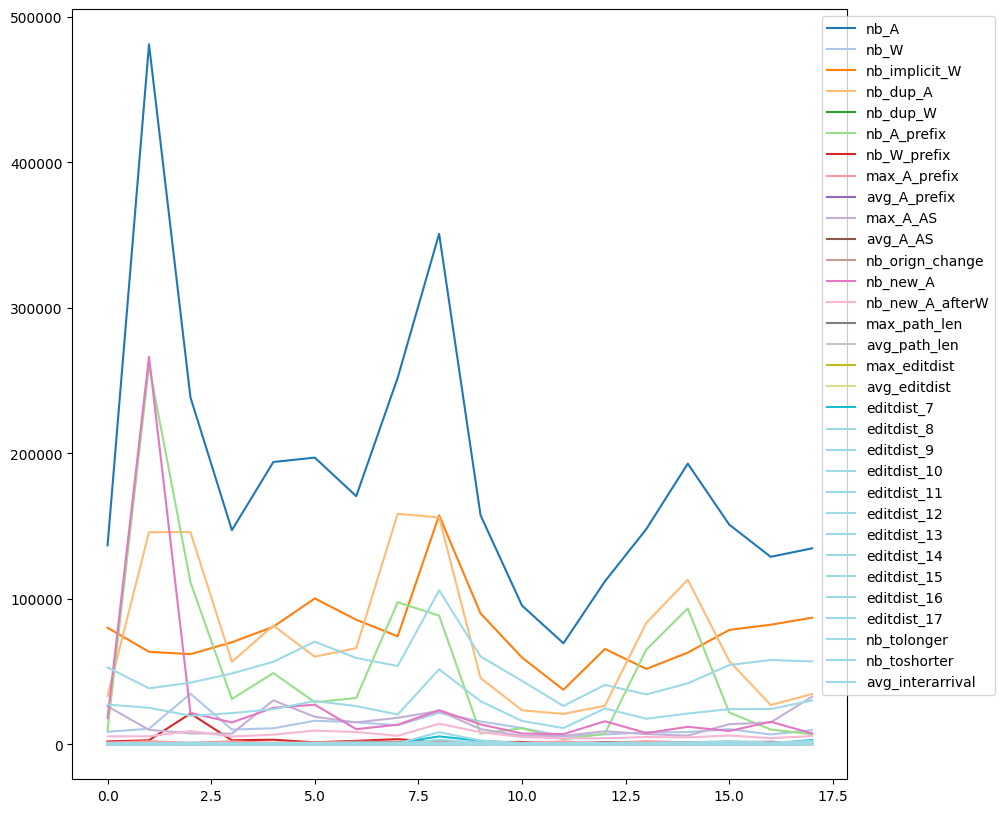

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

data = pd.read_json(folder + "anomaly/test_taiwan/transform/Features/Features_5.json")

num_cols = len(data.columns)

# Generate a color map with as many unique colors as there are columns
color_map = plt.colormaps['tab20']  # 'tab20' is a good choice for up to 20 unique colors
colors = color_map(range(num_cols))

fig, ax = plt.subplots(figsize=(10, 10))
for i, col in enumerate(data.columns):
    ax.plot(data.index, data[col], label=col, color=colors[i % len(colors)])

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

In [35]:
import pandas as pd
import datetime

data = pd.read_json("/home/hb/BGP_data_analysis/bml/BML/dataset/anomaly/test_taiwan/transform/Features/Features_5.json")

# Check the number of rows in the DataFrame
num_rows = len(data)
print(f"Number of rows in the DataFrame: {num_rows}")

# Define the start and end times
start_time = datetime.datetime(2019, 5, 8, 14, 0, 0) # Start time
end_time = datetime.datetime(2019, 5, 8, 15, 30, 0)  # End time

# Generate a list of timestamps for each 5-minute interval between start_time and end_time
timestamps = pd.date_range(start=start_time, periods=num_rows, freq='5T')  # '5T' frequency is for 5 minutes

# Check if the length of timestamps matches the number of rows in the data
if len(timestamps) != len(data):
    raise ValueError("The number of timestamps does not match the number of rows in the data")

# Add the timestamps as a new column in the DataFrame
data['timestamp'] = timestamps

# Reorder columns to make 'timestamp' the first column
cols = ['timestamp'] + [col for col in data.columns if col != 'timestamp']
data = data[cols]

# Calculate the difference between consecutive rows
diff = data.diff().abs()

# Define the threshold for each column as mean + 1.5 * std
thresholds = diff.mean() + 3 * diff.std()

# Find rows where the difference exceeds the threshold
anomalies = (diff > thresholds).any(axis=1)

# Initialize the anomaly_status column with "no anomalies detected"
data['anomaly_status'] = "no anomalies detected"

# Label anomalies and add reasons
for idx in data[anomalies].index:
    reasons = []
    for col in data.columns[1:]:  # Skip timestamp column and anomaly_status column
        if col == 'anomaly_status':
            continue
        if diff.loc[idx, col] > thresholds[col]:
            reasons.append(f"{col}={data.loc[idx, col]}")
    if reasons:
        data.at[idx, 'anomaly_status'] = f"anomaly due to high value of {', '.join(reasons)}"
    else:
        data.at[idx, 'anomaly_status'] = "normal"

# Display the DataFrame to verify
print(data)

# Save the updated DataFrame to a new JSON file if needed
data.to_json("/home/hb/dataset_bgp/bgp_nlp_dataset/test_taiwan.json", orient='records', date_format='iso')

Number of rows in the DataFrame: 18
             timestamp    nb_A   nb_W  nb_implicit_W  nb_dup_A  nb_dup_W  \
0  2019-05-08 14:00:00  136710   8596          80094     33244       145   
1  2019-05-08 14:05:00  481128  10673          63574    145757       194   
2  2019-05-08 14:10:00  238459  34784          61950    145794       431   
3  2019-05-08 14:15:00  147155  10129          70119     56697       200   
4  2019-05-08 14:20:00  194011  11003          80787     81536       160   
5  2019-05-08 14:25:00  197039  16169         100243     60187       392   
6  2019-05-08 14:30:00  170517  15134          85607     66091       322   
7  2019-05-08 14:35:00  251893  13052          74228    158424       307   
8  2019-05-08 14:40:00  350853  21690         157371    155898       536   
9  2019-05-08 14:45:00  157432  15675          89943     45531       625   
10 2019-05-08 14:50:00   95348  11196          59615     23378       274   
11 2019-05-08 14:55:00   69421   5494          37472

In [36]:
data["anomaly_status"]

0                                 no anomalies detected
1       anomaly due to high value of nb_A_prefix=260191
2                                 no anomalies detected
3                                 no anomalies detected
4                                 no anomalies detected
5                                 no anomalies detected
6                                 no anomalies detected
7                                 no anomalies detected
8     anomaly due to high value of editdist_8=8291, ...
9                                 no anomalies detected
10                                no anomalies detected
11                                no anomalies detected
12                                no anomalies detected
13                                no anomalies detected
14                                no anomalies detected
15                                no anomalies detected
16                                no anomalies detected
17                                no anomalies d

# Graph features extraction

In [60]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "GraphFeatures")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 1s


In [87]:
import pandas as pd 
data = pd.read_json(folder+"/anomaly/GoogleLeak/transform/GraphFeatures/GraphFeatures_1.json")
data

,eigenvector,pagerank,clustering,triangles,degree,degree_centrality,average_neighbor_degree,node_clique_number,number_of_cliques,nb_of_nodes,nb_of_edges,diameter,assortativity,percolation_limit
0,0.004517,0.000181,0.042118,0.566256,2.698407,0.000489,55.053691,2.141564,2.595945,5524,7453,14,-0.094590,0.980567
1,0.004515,0.000181,0.042097,0.567944,2.697868,0.000488,55.435582,2.141308,2.595772,5534,7465,14,-0.094936,0.980692
2,0.004508,0.000181,0.041782,0.558186,2.694977,0.000487,55.219771,2.140043,2.591435,5534,7457,14,-0.094503,0.980580
3,0.004512,0.000181,0.041589,0.567016,2.697977,0.000487,55.496830,2.141077,2.596460,5536,7468,14,-0.094707,0.980664
4,0.004508,0.000181,0.041904,0.557564,2.695825,0.000487,55.035416,2.140611,2.590819,5533,7458,14,-0.094388,0.980568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.003509,0.000122,0.038637,0.510921,2.666504,0.000325,65.348040,2.128737,2.572544,8195,10926,14,-0.109811,0.982398
57,0.003513,0.000122,0.039157,0.522026,2.667236,0.000326,65.725117,2.130689,2.574009,8195,10929,14,-0.109826,0.982511
58,0.003503,0.000122,0.038472,0.510610,2.664390,0.000325,65.601612,2.127927,2.570976,8200,10924,14,-0.109534,0.982451
59,0.003515,0.000122,0.039331,0.521511,2.668860,0.000325,65.752826,2.129311,2.577940,8205,10949,14,-0.109496,0.982539


In [88]:
# Define thresholds for anomalies
# You can adjust these thresholds based on your specific requirements
threshold_edges = data['nb_of_edges'].mean() * 1.5
threshold_nodes = data['nb_of_nodes'].mean() * 1.5
threshold_avg_neighbor_degree = data['average_neighbor_degree'].mean() * 1.5

# Create a new column 'anomaly' with 1 indicating an anomaly and 0 indicating normal
data['anomaly'] = ((data['nb_of_edges'] > threshold_edges) |
                 (data['nb_of_nodes'] > threshold_nodes) |
                 (data['average_neighbor_degree'] > threshold_avg_neighbor_degree)).astype(int)


# data.to_csv('bgp_graph_features_with_anomaly.csv', index=False)


In [82]:
anomaly_count = data['anomaly'].sum()
anomaly_count

9

<Axes: >

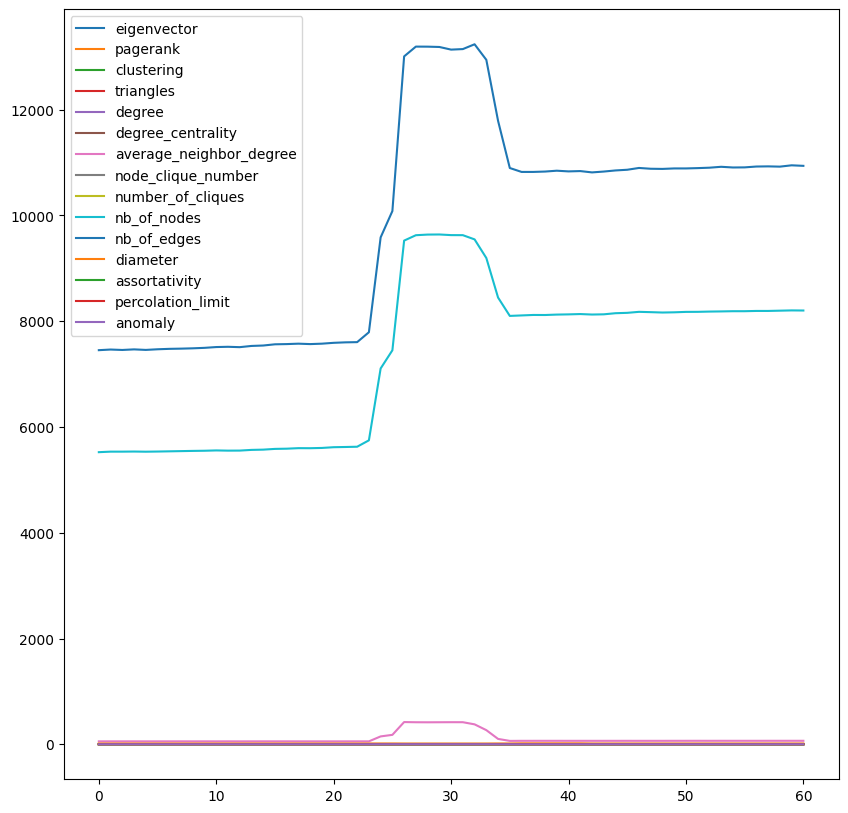

In [89]:
data.plot(figsize=(10,10))

## Hijacking

In [130]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc06"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "BalancerHijack",
    "label": "hijack",
    "start_time": utils.getTimestamp(2023, 9, 20, 0, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2023, 9, 20, 10, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 1s


In [131]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 3
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/3 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 3s


<Axes: >

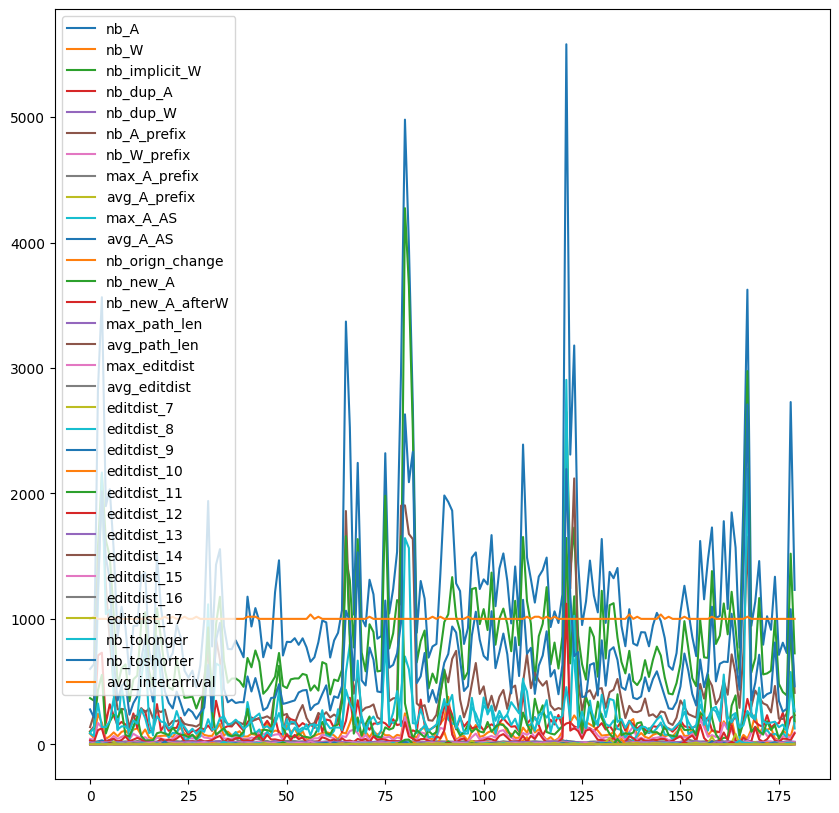

In [132]:
import pandas as pd 
data = pd.read_json(folder+"/hijack/BalancerHijack/transform/Features/Features_1.json")
data.plot(figsize=(10,10))

In [133]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "RoutesFeatures")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs")

################
# Run jobs list 
################
Number of processes to execute: 3
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/3 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 1h 1m 24s


<Axes: >

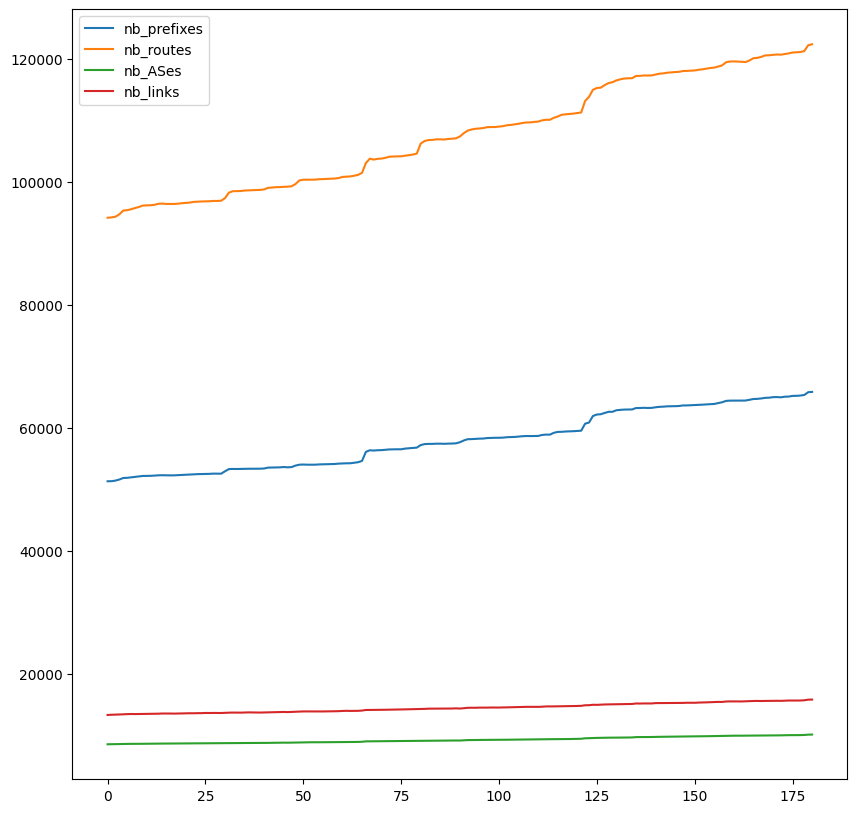

In [134]:
import pandas as pd 
data = pd.read_json("/home/hb/BGP_data_analysis/bml/BML/dataset/hijack/BalancerHijack/transform/RoutesFeatures/RoutesFeatures_1.json")
data.plot(figsize=(10,10))

In [114]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "HijackAnalyze")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs")

################
# Run jobs list 
################
Number of processes to execute: 2
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/2 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 22s


In [ ]:
import pandas as pd 
data = pd.read_json("/home/hb/BGP_data_analysis/bml/BML/dataset/hijack/BalancerHijack/transform/RoutesFeatures/RoutesFeatures_1.json")
data.plot(figsize=(10,10))

## BalancerHijackFull

In [127]:
from BML.data import Dataset
from BML import utils

#################
# Data collection

folder = "dataset/"
dataset = Dataset(folder)

dataset.setParams({
    "PrimingPeriod": 10*60, # 10 hours of priming data
    "IpVersion": [4], # only IPv4 routes
    "Collectors": ["rrc06"], # rrc06: at Otemachi, Japan 
})

dataset.setPeriodsOfInterests([
    {
    "name": "BalancerHijackFull",
    "label": "hijack",
    "start_time": utils.getTimestamp(2023, 9, 20, 0, 0, 0),  # August 25, 2017, 3:00 UTC
    "end_time": utils.getTimestamp(2023, 9, 21, 0, 0, 0)  # August 25, 2017, 4:00 UTC
    }
])


# run the data collection
utils.runJobs(dataset.getJobs(), folder+"collect_jobs") 


################
# Run jobs list 
################
Number of processes to execute: 1
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/collect_jobs/queue.log


  0%|          | 0/1 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 21m 19s


In [128]:
# graph features extraction every minute
datTran = DatasetTransformation(folder, "BML.transform", "Features")

datTran.setParams({
        "global":{
            "Period": 1,
        }
    })

# run the data transformation
utils.runJobs(datTran.getJobs(), folder+"transform_jobs") 

################
# Run jobs list 
################
Number of processes to execute: 3
Number of processes in parallel: 1
Processing queue: started
To monitor the execution run: watch -n 1 cat dataset/transform_jobs/queue.log


  0%|          | 0/3 [00:00<?, ?it/s]

Processing queue: finish
Computation time: 0h 0m 55s


<Axes: >

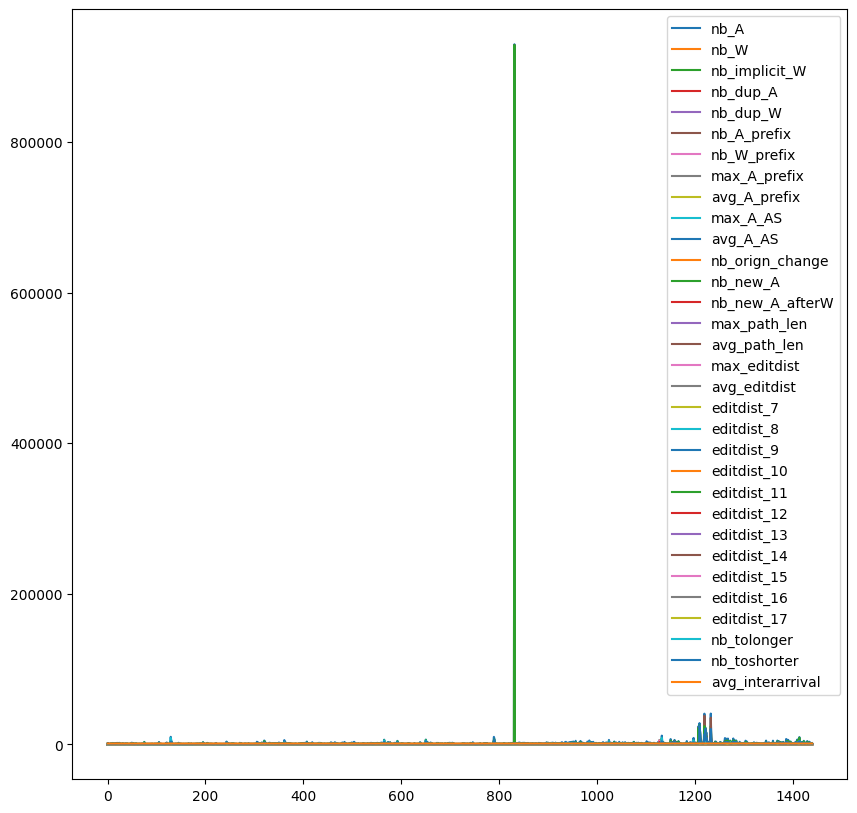

In [129]:
import pandas as pd 
data = pd.read_json(folder+"/hijack/BalancerHijackFull/transform/Features/Features_1.json")
data.plot(figsize=(10,10))